
# Homework 3: Naïve Bayes and Decision Trees

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

## Load Datasets

In [3]:
np.random.seed(42)
mushroom = fetch_ucirepo(id=73)
X_mushroom = mushroom.data.features
y_mushroom = mushroom.data.targets

print(f"Mushroom dataset shape: {X_mushroom.shape}")
print(f"Target distribution:\n{y_mushroom.value_counts()}")
print(f"\nFeature names: {list(X_mushroom.columns)}")

# Load Congressional Voting Records Dataset
print("\n2. Loading Congressional Voting Records Dataset...")
congressional_voting_records = fetch_ucirepo(id=105)
X_voting = congressional_voting_records.data.features
y_voting = congressional_voting_records.data.targets

print(f"\nVoting dataset shape: {X_voting.shape}")
print(f"Target distribution:\n{y_voting.value_counts()}")
print(f"\nFeature names: {list(X_voting.columns)}")

# Handle missing values - treat as separate category
X_mushroom = X_mushroom.fillna('missing')
X_voting = X_voting.fillna('missing')


Mushroom dataset shape: (8124, 22)
Target distribution:
poisonous
e            4208
p            3916
Name: count, dtype: int64

Feature names: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

2. Loading Congressional Voting Records Dataset...

Voting dataset shape: (435, 16)
Target distribution:
Class     
democrat      267
republican    168
Name: count, dtype: int64

Feature names: ['handicapped-infants', 'water-project-cost-sharing', 'adoption-of-the-budget-resolution', 'physician-fee-freeze', 'el-salvador-aid', 'religious-groups-in-schools', 'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile', 'immigration', 'synfuels-corporation-cutback', 'education-spendin

## NAÏVE BAYES IMPLEMENTATION

In [4]:
class NaiveBayesClassifier:
    """
    Naïve Bayes classifier for categorical features.
    Uses Laplace smoothing to handle zero probabilities.
    """
    
    def __init__(self, alpha=1.0):
        """
        Parameters:
        -----------
        alpha : float
            Smoothing parameter (Laplace smoothing). Default is 1.0.
        """
        self.alpha = alpha
        self.class_priors = {}
        self.feature_probs = {}
        self.classes = None
        self.features = None
        
    def fit(self, X, y):
        """
        Train the Naïve Bayes classifier.
        
        Parameters:
        -----------
        X : DataFrame
            Training features (categorical)
        y : Series or DataFrame
            Training labels
        """
        if isinstance(y, pd.DataFrame):
            y = y.iloc[:, 0]
        
        self.classes = y.unique()
        self.features = X.columns.tolist()
        n_samples = len(y)
        
        # Calculate class priors P(C)
        for c in self.classes:
            self.class_priors[c] = np.sum(y == c) / n_samples
        
        # Calculate conditional probabilities P(X_i | C) for each feature
        self.feature_probs = {}
        
        for feature in self.features:
            self.feature_probs[feature] = {}
            feature_values = X[feature].unique()
            
            for c in self.classes:
                self.feature_probs[feature][c] = {}
                X_c = X[y == c]
                n_c = len(X_c)
                
                # Count occurrences and apply Laplace smoothing
                for value in feature_values:
                    count = np.sum(X_c[feature] == value)
                    # Laplace smoothing: (count + alpha) / (n_c + alpha * n_values)
                    prob = (count + self.alpha) / (n_c + self.alpha * len(feature_values))
                    self.feature_probs[feature][c][value] = prob
                
                # Store number of unique values for unseen values
                self.feature_probs[feature][c]['_n_values'] = len(feature_values)
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X.
        
        Returns:
        --------
        probs : dict
            Dictionary mapping each class to its probability for each sample
        """
        predictions = []
        
        for idx in range(len(X)):
            class_probs = {}
            
            for c in self.classes:
                # Start with log prior
                log_prob = np.log(self.class_priors[c])
                
                # Add log conditional probabilities
                for feature in self.features:
                    value = X.iloc[idx][feature]
                    
                    if value in self.feature_probs[feature][c]:
                        prob = self.feature_probs[feature][c][value]
                    else:
                        # Handle unseen values with smoothing
                        n_values = self.feature_probs[feature][c]['_n_values']
                        prob = self.alpha / (len(X) + self.alpha * n_values)
                    
                    log_prob += np.log(prob)
                
                class_probs[c] = log_prob
            
            predictions.append(class_probs)
        
        return predictions
    
    def predict(self, X):
        """
        Predict class labels for X.
        
        Returns:
        --------
        predictions : array
            Predicted class labels
        """
        probs = self.predict_proba(X)
        predictions = [max(p, key=p.get) for p in probs]
        return np.array(predictions)

## Decision Tree

In [5]:
class DecisionTreeNode:
    """Node in a decision tree."""
    
    def __init__(self, feature=None, branches=None, value=None, is_leaf=False):
        self.feature = feature  # Feature to split on
        self.branches = branches or {}  # Dictionary mapping feature values to child nodes
        self.value = value  # Class label (for leaf nodes)
        self.is_leaf = is_leaf


class DecisionTreeClassifier_Custom:
    """
    Decision Tree classifier for categorical features.
    Uses information gain for splitting.
    """
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        """
        Parameters:
        -----------
        max_depth : int or None
            Maximum depth of the tree
        min_samples_split : int
            Minimum samples required to split a node
        min_samples_leaf : int
            Minimum samples required at a leaf node
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None
        self.features = None
        
    def entropy(self, y):
        """Calculate entropy of labels."""
        counts = Counter(y)
        total = len(y)
        ent = 0
        for count in counts.values():
            p = count / total
            if p > 0:
                ent -= p * np.log2(p)
        return ent
    
    def information_gain(self, X, y, feature):
        """Calculate information gain for a feature."""
        parent_entropy = self.entropy(y)
        
        # Calculate weighted average of child entropies
        values = X[feature].unique()
        weighted_entropy = 0
        
        for value in values:
            mask = X[feature] == value
            subset_y = y[mask]
            weight = len(subset_y) / len(y)
            weighted_entropy += weight * self.entropy(subset_y)
        
        return parent_entropy - weighted_entropy
    
    def best_split(self, X, y, available_features):
        """Find the best feature to split on."""
        best_gain = -1
        best_feature = None
        
        for feature in available_features:
            gain = self.information_gain(X, y, feature)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
        
        return best_feature, best_gain
    
    def build_tree(self, X, y, depth=0, available_features=None):
        """Recursively build the decision tree."""
        if available_features is None:
            available_features = list(X.columns)
        
        # Base cases
        n_samples = len(y)
        n_classes = len(y.unique())
        
        # Stopping criteria
        if (n_classes == 1 or 
            n_samples < self.min_samples_split or 
            len(available_features) == 0 or
            (self.max_depth is not None and depth >= self.max_depth)):
            # Create leaf node with majority class
            leaf_value = Counter(y).most_common(1)[0][0]
            return DecisionTreeNode(value=leaf_value, is_leaf=True)
        
        # Find best split
        best_feature, best_gain = self.best_split(X, y, available_features)
        
        if best_gain == 0:
            # No information gain, create leaf
            leaf_value = Counter(y).most_common(1)[0][0]
            return DecisionTreeNode(value=leaf_value, is_leaf=True)
        
        # Create internal node and recursively build subtrees
        branches = {}
        feature_values = X[best_feature].unique()
        
        for value in feature_values:
            mask = X[best_feature] == value
            subset_X = X[mask].reset_index(drop=True)
            subset_y = y[mask].reset_index(drop=True)
            
            # Check min_samples_leaf
            if len(subset_y) >= self.min_samples_leaf:
                # Remove used feature from available features for this branch
                new_available = [f for f in available_features if f != best_feature]
                branches[value] = self.build_tree(subset_X, subset_y, depth + 1, new_available)
            else:
                # Create leaf with majority class if subset too small
                leaf_value = Counter(y).most_common(1)[0][0]
                branches[value] = DecisionTreeNode(value=leaf_value, is_leaf=True)
        
        return DecisionTreeNode(feature=best_feature, branches=branches)
    
    def fit(self, X, y):
        """Train the decision tree classifier."""
        if isinstance(y, pd.DataFrame):
            y = y.iloc[:, 0]
        
        self.features = X.columns.tolist()
        self.root = self.build_tree(X.reset_index(drop=True), y.reset_index(drop=True))
        return self
    
    def predict_sample(self, sample, node):
        """Predict class for a single sample."""
        if node.is_leaf:
            return node.value
        
        feature_value = sample[node.feature]
        
        if feature_value in node.branches:
            return self.predict_sample(sample, node.branches[feature_value])
        else:
            # Handle unseen value: return most common class in this node
            # We'll use a simple heuristic: return the first branch's prediction
            if node.branches:
                first_branch = list(node.branches.values())[0]
                return self.predict_sample(sample, first_branch)
            return node.value
    
    def predict(self, X):
        """Predict class labels for X."""
        predictions = []
        for idx in range(len(X)):
            pred = self.predict_sample(X.iloc[idx], self.root)
            predictions.append(pred)
        return np.array(predictions)


## Evaluation

In [6]:
def evaluate_classifier(y_true, y_pred, dataset_name, classifier_name):
    """Evaluate and print classifier performance."""
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.iloc[:, 0]
    
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n{classifier_name} on {dataset_name}")
    print(f"{'='*60}")
    print(f"Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print(f"\nConfusion Matrix:")
    print(cm)
    
    return acc, cm


def plot_confusion_matrix(cm, labels, title):
    """Plot confusion matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

## Data Splitting

In [7]:
X_train_m, X_temp_m, y_train_m, y_temp_m = train_test_split(
    X_mushroom, y_mushroom, test_size=0.2, random_state=42, stratify=y_mushroom
)
X_dev_m, X_test_m, y_dev_m, y_test_m = train_test_split(
    X_temp_m, y_temp_m, test_size=0.5, random_state=42, stratify=y_temp_m
)

print(f"\nMushroom Dataset Split:")
print(f"  Training set: {len(X_train_m)} samples")
print(f"  Development set: {len(X_dev_m)} samples")
print(f"  Test set: {len(X_test_m)} samples")

# Split Voting dataset: 80% train, 10% dev, 10% test
X_train_v, X_temp_v, y_train_v, y_temp_v = train_test_split(
    X_voting, y_voting, test_size=0.2, random_state=42, stratify=y_voting
)
X_dev_v, X_test_v, y_dev_v, y_test_v = train_test_split(
    X_temp_v, y_temp_v, test_size=0.5, random_state=42, stratify=y_temp_v
)

print(f"\nVoting Dataset Split:")
print(f"  Training set: {len(X_train_v)} samples")
print(f"  Development set: {len(X_dev_v)} samples")
print(f"  Test set: {len(X_test_v)} samples")


Mushroom Dataset Split:
  Training set: 6499 samples
  Development set: 812 samples
  Test set: 813 samples

Voting Dataset Split:
  Training set: 348 samples
  Development set: 43 samples
  Test set: 44 samples


# Mushroom Dataset Experiments

In [8]:
print("\n--- Custom Naïve Bayes ---")
nb_mushroom = NaiveBayesClassifier(alpha=1.0)
nb_mushroom.fit(X_train_m, y_train_m)

# Evaluate on dev set
y_pred_nb_m_dev = nb_mushroom.predict(X_dev_m)
acc_nb_m_dev, cm_nb_m_dev = evaluate_classifier(
    y_dev_m, y_pred_nb_m_dev, "Mushroom (Dev)", "Custom Naïve Bayes"
)

# Evaluate on test set
y_pred_nb_m_test = nb_mushroom.predict(X_test_m)
acc_nb_m_test, cm_nb_m_test = evaluate_classifier(
    y_test_m, y_pred_nb_m_test, "Mushroom (Test)", "Custom Naïve Bayes"
)

# Decision Tree - Custom Implementation
print("\n--- Custom Decision Tree ---")
# Try different hyperparameters
dt_configs = [
    {"max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
    {"max_depth": 10, "min_samples_split": 5, "min_samples_leaf": 2},
    {"max_depth": 15, "min_samples_split": 10, "min_samples_leaf": 5},
]

best_dt_m_acc = 0
best_dt_m_config = None
best_dt_m_model = None

for i, config in enumerate(dt_configs):
    print(f"\nConfig {i+1}: {config}")
    dt_mushroom = DecisionTreeClassifier_Custom(**config)
    dt_mushroom.fit(X_train_m, y_train_m)
    
    y_pred_dt_m_dev = dt_mushroom.predict(X_dev_m)
    acc = accuracy_score(y_dev_m.iloc[:, 0] if isinstance(y_dev_m, pd.DataFrame) else y_dev_m, 
                         y_pred_dt_m_dev)
    print(f"Dev Accuracy: {acc:.4f}")
    
    if acc > best_dt_m_acc:
        best_dt_m_acc = acc
        best_dt_m_config = config
        best_dt_m_model = dt_mushroom

print(f"\nBest Configuration: {best_dt_m_config}")
y_pred_dt_m_test = best_dt_m_model.predict(X_test_m)
acc_dt_m_test, cm_dt_m_test = evaluate_classifier(
    y_test_m, y_pred_dt_m_test, "Mushroom (Test)", "Custom Decision Tree"
)

# Scikit-learn comparison
print("\n--- Scikit-learn Comparison ---")

# Encode categorical features for sklearn
from sklearn.preprocessing import LabelEncoder
le_m = LabelEncoder()

# Encode all features
X_train_m_encoded = X_train_m.apply(le_m.fit_transform)
X_test_m_encoded = X_test_m.apply(lambda col: le_m.fit_transform(col.astype(str)))

# Encode target
y_train_m_encoded = le_m.fit_transform(y_train_m.iloc[:, 0] if isinstance(y_train_m, pd.DataFrame) else y_train_m)
y_test_m_encoded = le_m.transform(y_test_m.iloc[:, 0] if isinstance(y_test_m, pd.DataFrame) else y_test_m)

# Sklearn Naïve Bayes
nb_sklearn_m = CategoricalNB(alpha=1.0)
nb_sklearn_m.fit(X_train_m_encoded, y_train_m_encoded)
y_pred_nb_sklearn_m = nb_sklearn_m.predict(X_test_m_encoded)
acc_nb_sklearn_m, _ = evaluate_classifier(
    y_test_m_encoded, y_pred_nb_sklearn_m, "Mushroom (Test)", "Sklearn Naïve Bayes"
)

# Sklearn Decision Tree
dt_sklearn_m = DecisionTreeClassifier(random_state=42)
dt_sklearn_m.fit(X_train_m_encoded, y_train_m_encoded)
y_pred_dt_sklearn_m = dt_sklearn_m.predict(X_test_m_encoded)
acc_dt_sklearn_m, _ = evaluate_classifier(
    y_test_m_encoded, y_pred_dt_sklearn_m, "Mushroom (Test)", "Sklearn Decision Tree"
)



--- Custom Naïve Bayes ---

Custom Naïve Bayes on Mushroom (Dev)
Accuracy: 0.9557 (95.57%)

Confusion Matrix:
[[417   4]
 [ 32 359]]

Custom Naïve Bayes on Mushroom (Test)
Accuracy: 0.9360 (93.60%)

Confusion Matrix:
[[418   3]
 [ 49 343]]

--- Custom Decision Tree ---

Config 1: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
Dev Accuracy: 1.0000

Config 2: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
Dev Accuracy: 1.0000

Config 3: {'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 5}
Dev Accuracy: 1.0000

Best Configuration: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}

Custom Decision Tree on Mushroom (Test)
Accuracy: 1.0000 (100.00%)

Confusion Matrix:
[[421   0]
 [  0 392]]

--- Scikit-learn Comparison ---

Sklearn Naïve Bayes on Mushroom (Test)
Accuracy: 0.9385 (93.85%)

Confusion Matrix:
[[418   3]
 [ 47 345]]

Sklearn Decision Tree on Mushroom (Test)
Accuracy: 1.0000 (100.00%)

Confusion Matrix:
[[421   

## Voting Dataset Experiments

In [9]:
# Naïve Bayes - Custom Implementation
print("\n--- Custom Naïve Bayes ---")
nb_voting = NaiveBayesClassifier(alpha=1.0)
nb_voting.fit(X_train_v, y_train_v)

y_pred_nb_v_dev = nb_voting.predict(X_dev_v)
acc_nb_v_dev, cm_nb_v_dev = evaluate_classifier(
    y_dev_v, y_pred_nb_v_dev, "Voting (Dev)", "Custom Naïve Bayes"
)

y_pred_nb_v_test = nb_voting.predict(X_test_v)
acc_nb_v_test, cm_nb_v_test = evaluate_classifier(
    y_test_v, y_pred_nb_v_test, "Voting (Test)", "Custom Naïve Bayes"
)

# Decision Tree - Custom Implementation
print("\n--- Custom Decision Tree ---")
best_dt_v_acc = 0
best_dt_v_config = None
best_dt_v_model = None

for i, config in enumerate(dt_configs):
    print(f"\nConfig {i+1}: {config}")
    dt_voting = DecisionTreeClassifier_Custom(**config)
    dt_voting.fit(X_train_v, y_train_v)
    
    y_pred_dt_v_dev = dt_voting.predict(X_dev_v)
    acc = accuracy_score(y_dev_v.iloc[:, 0] if isinstance(y_dev_v, pd.DataFrame) else y_dev_v,
                         y_pred_dt_v_dev)
    print(f"Dev Accuracy: {acc:.4f}")
    
    if acc > best_dt_v_acc:
        best_dt_v_acc = acc
        best_dt_v_config = config
        best_dt_v_model = dt_voting

print(f"\nBest Configuration: {best_dt_v_config}")
y_pred_dt_v_test = best_dt_v_model.predict(X_test_v)
acc_dt_v_test, cm_dt_v_test = evaluate_classifier(
    y_test_v, y_pred_dt_v_test, "Voting (Test)", "Custom Decision Tree"
)

# Scikit-learn comparison
print("\n--- Scikit-learn Comparison ---")

# Encode features for sklearn
X_train_v_encoded = X_train_v.apply(lambda col: le_m.fit_transform(col.astype(str)))
X_test_v_encoded = X_test_v.apply(lambda col: le_m.fit_transform(col.astype(str)))

y_train_v_encoded = le_m.fit_transform(y_train_v.iloc[:, 0] if isinstance(y_train_v, pd.DataFrame) else y_train_v)
y_test_v_encoded = le_m.transform(y_test_v.iloc[:, 0] if isinstance(y_test_v, pd.DataFrame) else y_test_v)

# Sklearn Naïve Bayes
nb_sklearn_v = CategoricalNB(alpha=1.0)
nb_sklearn_v.fit(X_train_v_encoded, y_train_v_encoded)
y_pred_nb_sklearn_v = nb_sklearn_v.predict(X_test_v_encoded)
acc_nb_sklearn_v, _ = evaluate_classifier(
    y_test_v_encoded, y_pred_nb_sklearn_v, "Voting (Test)", "Sklearn Naïve Bayes"
)

# Sklearn Decision Tree
dt_sklearn_v = DecisionTreeClassifier(random_state=42)
dt_sklearn_v.fit(X_train_v_encoded, y_train_v_encoded)
y_pred_dt_sklearn_v = dt_sklearn_v.predict(X_test_v_encoded)
acc_dt_sklearn_v, _ = evaluate_classifier(
    y_test_v_encoded, y_pred_dt_sklearn_v, "Voting (Test)", "Sklearn Decision Tree"
)


--- Custom Naïve Bayes ---

Custom Naïve Bayes on Voting (Dev)
Accuracy: 0.9070 (90.70%)

Confusion Matrix:
[[24  2]
 [ 2 15]]

Custom Naïve Bayes on Voting (Test)
Accuracy: 0.9773 (97.73%)

Confusion Matrix:
[[26  1]
 [ 0 17]]

--- Custom Decision Tree ---

Config 1: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
Dev Accuracy: 0.9535

Config 2: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
Dev Accuracy: 0.9535

Config 3: {'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 5}
Dev Accuracy: 0.9302

Best Configuration: {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}

Custom Decision Tree on Voting (Test)
Accuracy: 0.9545 (95.45%)

Confusion Matrix:
[[26  1]
 [ 1 16]]

--- Scikit-learn Comparison ---

Sklearn Naïve Bayes on Voting (Test)
Accuracy: 0.9773 (97.73%)

Confusion Matrix:
[[27  0]
 [ 1 16]]

Sklearn Decision Tree on Voting (Test)
Accuracy: 1.0000 (100.00%)

Confusion Matrix:
[[27  0]
 [ 0 17]]


## Summary



 Dataset Classifier  Test Accuracy
Mushroom  Custom NB       0.936039
Mushroom  Custom DT       1.000000
Mushroom Sklearn NB       0.938499
Mushroom Sklearn DT       1.000000
  Voting  Custom NB       0.977273
  Voting  Custom DT       0.954545
  Voting Sklearn NB       0.977273
  Voting Sklearn DT       1.000000


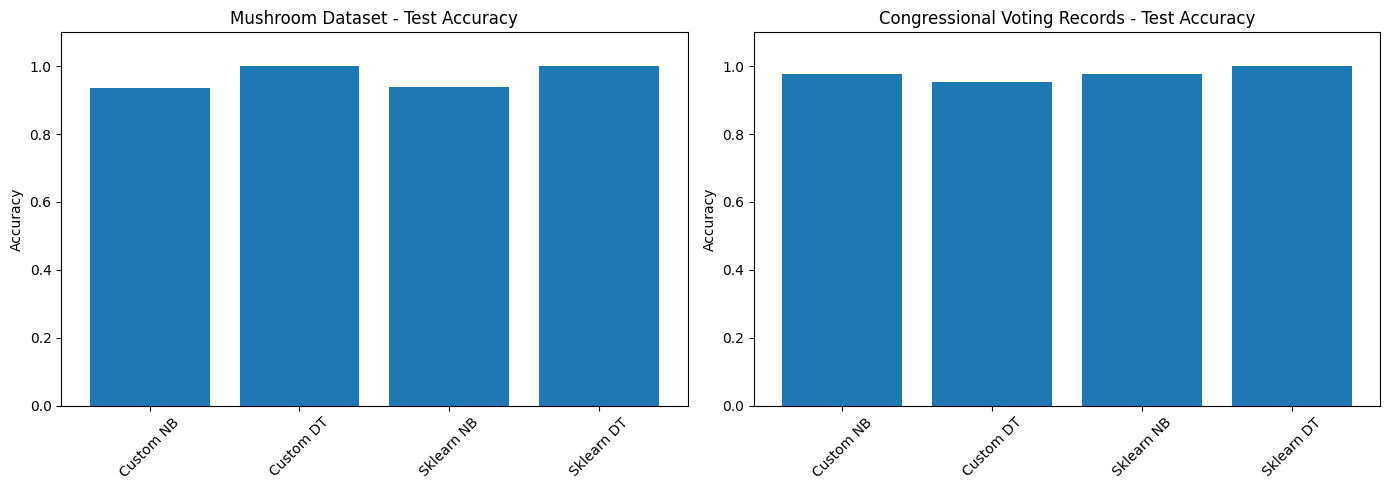

In [10]:
results_df = pd.DataFrame({
    'Dataset': ['Mushroom', 'Mushroom', 'Mushroom', 'Mushroom',
                'Voting', 'Voting', 'Voting', 'Voting'],
    'Classifier': ['Custom NB', 'Custom DT', 'Sklearn NB', 'Sklearn DT',
                   'Custom NB', 'Custom DT', 'Sklearn NB', 'Sklearn DT'],
    'Test Accuracy': [acc_nb_m_test, acc_dt_m_test, acc_nb_sklearn_m, acc_dt_sklearn_m,
                      acc_nb_v_test, acc_dt_v_test, acc_nb_sklearn_v, acc_dt_sklearn_v]
})

print("\n")
print(results_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mushroom results
mushroom_results = results_df[results_df['Dataset'] == 'Mushroom']
axes[0].bar(mushroom_results['Classifier'], mushroom_results['Test Accuracy'])
axes[0].set_title('Mushroom Dataset - Test Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1.1])
axes[0].tick_params(axis='x', rotation=45)

# Voting results
voting_results = results_df[results_df['Dataset'] == 'Voting']
axes[1].bar(voting_results['Classifier'], voting_results['Test Accuracy'])
axes[1].set_title('Congressional Voting Records - Test Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([0, 1.1])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
